In [192]:
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import sklearn
from sklearn.model_selection import train_test_split


import torchvision
from torchvision import datasets, models, transforms

import time
import io
import os
import copy
import data

plt.ion()

In [193]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
       transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

#Loading
data_dir = '../datasets/train'

data = datasets.ImageFolder(data_dir,data_transforms)
data_labels = data.classes
num_classes = len(set(data_labels))

#Splitting
lenTrain = int(len(data)*0.8)
lenVal = int(int(len(data)) - lenTrain)
lengths = [lenTrain, lenVal]
train, val = torch.utils.data.random_split(data, lengths)

#Loaders
dataloader_train = torch.utils.data.DataLoader(train, batch_size=4,shuffle=True, num_workers=4)
dataloader_val = torch.utils.data.DataLoader(val, batch_size=4,shuffle=True, num_workers=4)

dataset_sizes_train = len(train)
dataset_sizes_val = len(val)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [203]:
def model_results(train_loss, val_loss, title):#, train_acc, val_acc):# train_f1, val_f1):
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(train_loss, 'b-', label='Train')
    plt.plot(val_loss, 'r-', label='Validation')
    plt.legend(loc='upper right')
    plt.show()

In [195]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_f1 = 0.0
    
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    train_f1 = []
    val_f1 = []
    
    f1 = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_f1 = 0

            # Iterate over data.
            if phase == 'train': 
                for inputs, labels in dataloader_train:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    #print(labels.data.type())
                    #print(preds.type())
                    labels_cpu = labels.cpu().numpy()
                    predictions_cpu = preds.cpu().numpy()
                    running_f1 = sklearn.metrics.f1_score(labels_cpu, predictions_cpu, average='macro')
                    f1.append(running_f1)
            
            if phase == 'val': 
                for inputs, labels in dataloader_val:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                    labels_cpu = labels.cpu().numpy()
                    predictions_cpu = preds.cpu().numpy()
                    running_f1 = sklearn.metrics.f1_score(labels_cpu, predictions_cpu, average='macro')
                    f1.append(running_f1)

            
            if phase == 'train':
                epoch_loss = running_loss / dataset_sizes_train
                epoch_acc = running_corrects.double() / dataset_sizes_train
                epoch_f1 = np.average(np.array(f1))
                
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
                train_f1.append(epoch_f1)
                
                
            if phase == 'val':
                epoch_loss = running_loss / dataset_sizes_val
                epoch_acc = running_corrects.double() / dataset_sizes_val
                epoch_f1 = np.average(np.array(f1))
                
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
                val_f1.append(epoch_f1)

            print('{} Loss: {:.4f} Acc: {:.4f} F1:{:.4f}'.format(
                phase, epoch_loss, epoch_acc, epoch_f1))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1

        print()
        torch.save(model, './models/vgg3_model.pth')

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best val F1: {:4f}'.format(best_f1))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, val_loss, train_acc, val_acc, train_f1, val_f1

In [196]:
model_vgg = models.vgg19_bn(pretrained=True)

#for param in model_vgg.parameters():
#    param.requires_grad = False

model_vgg.classifier[6] = nn.Linear(4096,num_classes)
#num_ftrs = model_conv.fc.in_features
#model_conv.fc = nn.Linear(num_ftrs, num_classes)

model_vgg = model_vgg.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_vgg.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_vgg, train_loss, val_loss, train_acc, val_acc, train_f1, val_f1 = train_model(model_vgg, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)
torch.save(model_vgg, './models/vgg3final_model.pth')

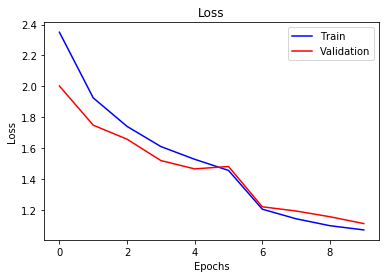

In [205]:
model_results(train_loss, val_loss,'Loss')

In [204]:
print(train_loss)
print(min(train_loss))

[2.350505995952566, 1.9253804143299267, 1.7407489718891562, 1.6102081557948726, 1.5276977187746488, 1.4556828826377044, 1.204530639180373, 1.1423309449277483, 1.0975841454205686, 1.0703502986796816]
1.0703502986796816


In [206]:
print(val_loss)
print(min(val_loss))

[2.0024331913674756, 1.7487690958748798, 1.6577660863158252, 1.5194908611348057, 1.4655231742047765, 1.4811534589860256, 1.220053252376014, 1.1928059897993237, 1.155701231881271, 1.1113756452188768]
1.1113756452188768


In [215]:
train_acc_def = [float(elem) for elem in train_acc]
print(train_acc_def)
print(max(train_acc_def))

[0.36893513111795306, 0.46921875236983, 0.516433349005809, 0.5484506999529826, 0.5694720397979768, 0.5903872112599154, 0.6550437565407308, 0.6705140066431075, 0.6850439082098494, 0.6892906435320705]
0.6892906435320705


In [216]:
val_acc_def = [float(elem) for elem in val_acc]
print(val_acc_def)
print(max(val_acc_def))

[0.4679689395777724, 0.5168041737442368, 0.5447706867265227, 0.58632613443339, 0.5942732346517835, 0.5952438728463965, 0.6599126425624848, 0.665433147294346, 0.6752608590148023, 0.6874545013346275]
0.6874545013346275


In [217]:
print(train_f1)
print(max(train_f1))

[0.257132722254962, 0.3056179751237585, 0.3360003804967753, 0.3585419759460935, 0.37720619979097897, 0.3927665805072527, 0.4119698449629791, 0.42989605638234607, 0.44538094879183204, 0.45834457019192737]
0.45834457019192737


In [218]:
print(val_f1)
print(max(val_f1))

[0.27438664910273747, 0.3140727516437295, 0.34148105779020604, 0.3636569997650439, 0.38094401497556074, 0.3953716767518029, 0.4157129458594082, 0.4328166562669717, 0.44790555065528775, 0.46065037958886534]
0.46065037958886534


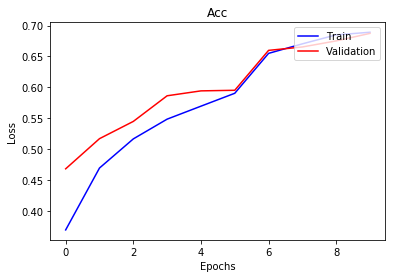

In [219]:
model_results(train_acc_def, val_acc_def,'Acc')

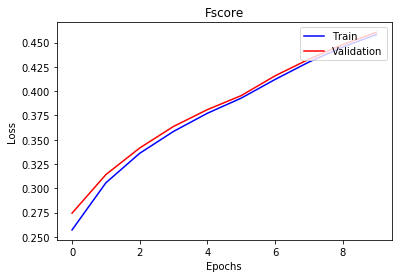

In [220]:
model_results(train_f1, val_f1,'Fscore')